# Validate Data Model Retraining for unit test

* We should be looking at number of standard deviations away from the mean, to normalize between distances, instead of the absolute value metric.

* The threshold for anomaly is this anyway. 


# note had to set PYTHONHASHSEED=42 in terminal for gensim W2V to provide reproducible results. 

### Still getting inconsistent results with the word vectors but colors seem to work, I suspect that the word vectors are too close to each other

Below I have increased the value of the vectors by mulitplying by 100. This seems to have worked. 


* Why do the values of the distances change so much during retraining? 
* Why does the most common entry have the highest anomaly score? 

In [2]:
import os
import numpy as np
import logging
import sompy
import SOM
from multiprocessing import Pool
import pandas as pd
import re
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize


np.random.seed(42)

import matplotlib.pyplot as plt 

CACHEDIR=/home/mcliffor/.cache/matplotlib
Using fontManager instance from /home/mcliffor/.cache/matplotlib/fontList.json
backend module://ipykernel.pylab.backend_inline version unknown
'pattern' package not found; tag filters are not available for English
backend module://ipykernel.pylab.backend_inline version unknown


In [4]:
def train(inp, map_size, iterations, parallelism):
    print(f'training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    #return model
    return som

def get_anomaly_score(logs, parallelism, model):

    #pool = Pool(parallelism)
    #dist = pool.map(calculate_anomaly_score, logs, model)
    #pool.close()
    #pool.join()
    dist = [] 
    for log in logs:
        dist.append(calculate_anomaly_score(log,model))
    
    return dist

def save_visualisation(dest):
    return None

def calculate_anomaly_score(log, model):
    """Compute a distance of a log entry to elements of SOM."""
    # convert log into vector using same word2vec model (here just going to grab from existing)
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log)#np.linalg.norm(som[x][y]-log)
            
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist


def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = Word2Vec([list(words[col])], min_count=1, size=vector_length, window=window_size, seed=42, workers=1)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)

def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def _preprocess(data):
    def to_str(x):
        """Convert all non-str lists to string lists for Word2Vec."""
        ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
        return ret

    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")

In [5]:
data_path = "/home/mcliffor/Desktop/zak_lad/log-anomaly-detector/validation_data/log_anomaly_detector-10000-events.json"

In [6]:
data = pd.read_json(data_path)

In [7]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [8]:
data[data.message == "rootCMDusrlocalbinmonitorapachestatsshdevnull"]

,message
6188,rootCMDusrlocalbinmonitorapachestatsshdevnull


In [9]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [10]:
data.message.value_counts()

DEBUGProcessedoutofpackages                            9786
ThreadodcsserverINFOComposetypestatedoneComposedone     213
rootCMDusrlocalbinmonitorapachestatsshdevnull             1
Name: message, dtype: int64

In [11]:
w2vmodel = create(data, 3,5)

consider setting layer size to a multiple of 4 for greater performance
collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
min_count=1 retains 3 unique words (100% of original 3, drops 0)
min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 3 dimensions: 1572 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 3 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 206056 effective words/s
job loop 

In [12]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = np.abs(transformed_data[:,1:])
#transformed_data = transformed_data[:,1:]

In [13]:
#transformed_data  = np.array([[5,8,100], [20,13,2],[30,31,45]]*200)
map_size = 16

In [14]:
transformed_data

array([[2.07785535, 0.96323067, 0.39087647],
       [2.07785535, 0.96323067, 0.39087647],
       [2.07785535, 0.96323067, 0.39087647],
       ...,
       [2.07785535, 0.96323067, 0.39087647],
       [2.07785535, 0.96323067, 0.39087647],
       [2.07785535, 0.96323067, 0.39087647]])

In [15]:
np.random.seed(42)
fp = np.abs(w2vmodel["message"].wv["rootCMDusrlocalbinmonitorapachestatsshdevnull"])
FP_Data = np.array(list(transformed_data) + [fp]*1000)
print(len(transformed_data))
print(len(FP_Data))

10000
11000


In [16]:
FP_Data[-1]

array([0.04579642, 0.11827677, 0.12030392])

In [17]:
model = train(transformed_data,map_size, 0, 2)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.112000, quantization error: 1.711021



training dataset is of size 10000


 epoch: 2 ---> elapsed time:  0.127000, quantization error: 0.153436

 epoch: 3 ---> elapsed time:  0.130000, quantization error: 0.020338

 epoch: 4 ---> elapsed time:  0.237000, quantization error: 0.036616

 epoch: 5 ---> elapsed time:  0.322000, quantization error: 0.033757

 epoch: 6 ---> elapsed time:  0.111000, quantization error: 0.031038

 epoch: 7 ---> elapsed time:  0.236000, quantization error: 0.038965

 epoch: 8 ---> elapsed time:  0.129000, quantization error: 0.035877

 epoch: 9 ---> elapsed time:  0.123000, quantization error: 0.032949

 epoch: 10 ---> elapsed time:  0.126000, quantization error: 0.030181

 epoch: 11 ---> elapsed time:  0.129000, quantization error: 0.027531

 epoch: 12 ---> elapsed time:  0.137000, quantization error: 0.034529

 epoch: 13 ---> elapsed time:  0.130000, quantization error: 0.031558

 epoch: 14 ---> elapsed time:  0.139000, quantization error: 0.028762

 epoch: 15 ---> elapsed time:  0.139000, quantization error: 0.026141

 epoch: 16 ---

In [18]:
#plt.imshow(model)

/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


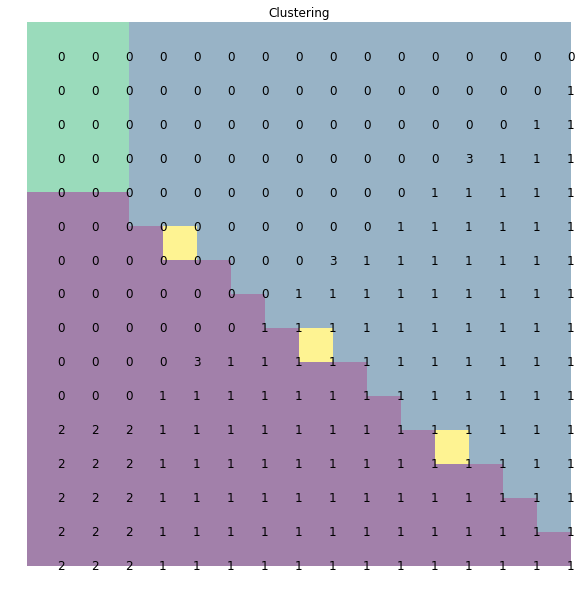

In [19]:
from sompy.visualization.hitmap import HitMapView
model.cluster(4)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a=hits.show(model, labelsize=12)

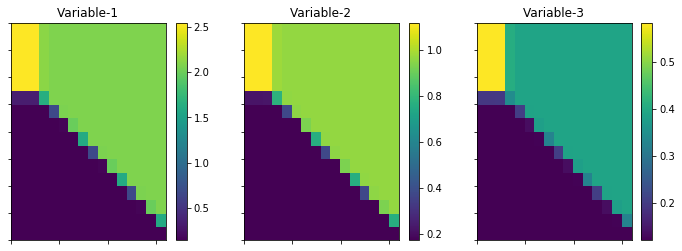

In [20]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

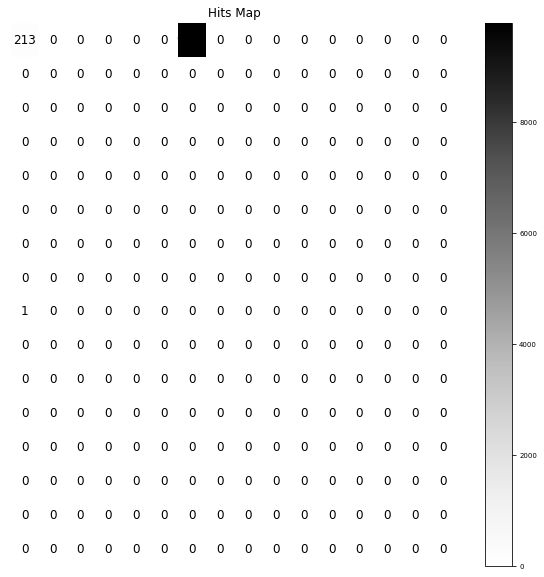

In [21]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [22]:
#plt.imshow(np.ones((4,4,3))*w2vmodel['message'].wv["DEBUGProcessedoutofpackages"])

In [23]:
#plt.imshow(np.ones((4,4,3))*w2vmodel['message'].wv["ThreadodcsserverINFOComposetypestatedoneComposedone"])

In [24]:
#plt.imshow(np.ones((4,4,3))*w2vmodel['message'].wv["rootCMDusrlocalbinmonitorapachestatsshdevnull"])

In [25]:
np.random.seed(42)
model_2 = train(FP_Data,map_size, 0, 2)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.114000, quantization error: 0.776358



training dataset is of size 11000


 epoch: 2 ---> elapsed time:  0.118000, quantization error: 0.551997

 epoch: 3 ---> elapsed time:  0.131000, quantization error: 0.166817

 epoch: 4 ---> elapsed time:  0.117000, quantization error: 0.164366

 epoch: 5 ---> elapsed time:  0.122000, quantization error: 0.130438

 epoch: 6 ---> elapsed time:  0.117000, quantization error: 0.125140

 epoch: 7 ---> elapsed time:  0.131000, quantization error: 0.119886

 epoch: 8 ---> elapsed time:  0.260000, quantization error: 0.114678

 epoch: 9 ---> elapsed time:  0.112000, quantization error: 0.109517

 epoch: 10 ---> elapsed time:  0.123000, quantization error: 0.104409

 epoch: 11 ---> elapsed time:  0.123000, quantization error: 0.099355

 epoch: 12 ---> elapsed time:  0.123000, quantization error: 0.094360

 epoch: 13 ---> elapsed time:  0.231000, quantization error: 0.089429

 epoch: 14 ---> elapsed time:  0.126000, quantization error: 0.084567

 epoch: 15 ---> elapsed time:  0.118000, quantization error: 0.079779

 epoch: 16 ---

In [26]:
DEBUG = w2vmodel["message"].wv["DEBUGProcessedoutofpackages"]
w2vmodel["message"].wv["DEBUGProcessedoutofpackages"]

array([2.0778553 , 0.96323067, 0.39087647], dtype=float32)

In [27]:
THRED=w2vmodel["message"].wv["ThreadodcsserverINFOComposetypestatedoneComposedone"]
w2vmodel["message"].wv["ThreadodcsserverINFOComposetypestatedoneComposedone"]

array([-4.2954783, -1.6723982, -1.2490478], dtype=float32)

In [28]:
print(w2vmodel["message"].wv["rootCMDusrlocalbinmonitorapachestatsshdevnull"])
fp = w2vmodel["message"].wv["rootCMDusrlocalbinmonitorapachestatsshdevnull"]

[-0.04579642  0.11827677 -0.12030392]


In [29]:
unique_message_vectors = {"DEBUG":DEBUG,"THRED":THRED,"FP":fp}

In [30]:
FP_Data[-1]

array([0.04579642, 0.11827677, 0.12030392])

In [31]:
#plt.imshow(model_2)

/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


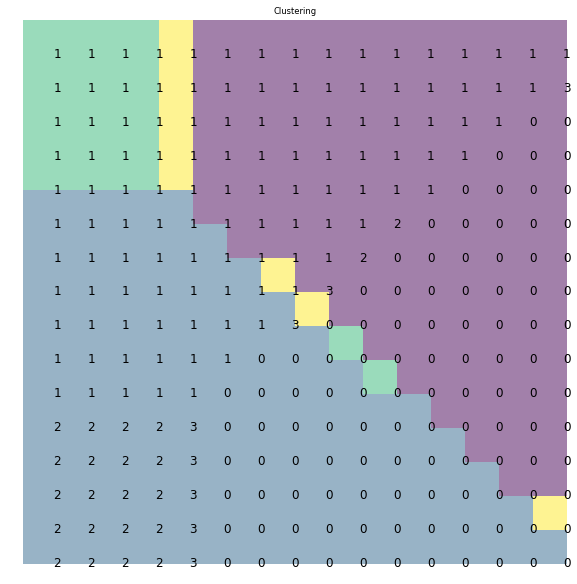

In [32]:
from sompy.visualization.hitmap import HitMapView
model_2.cluster(4)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a=hits.show(model_2, labelsize=12)

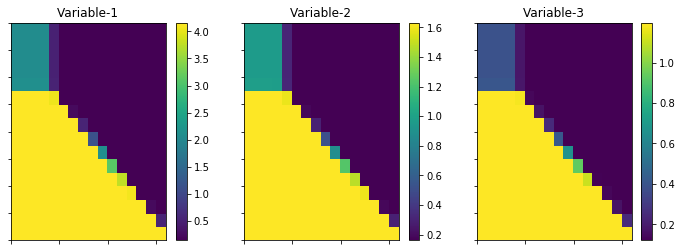

In [33]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(model_2, col_sz=4, which_dim="all", denormalize=True)

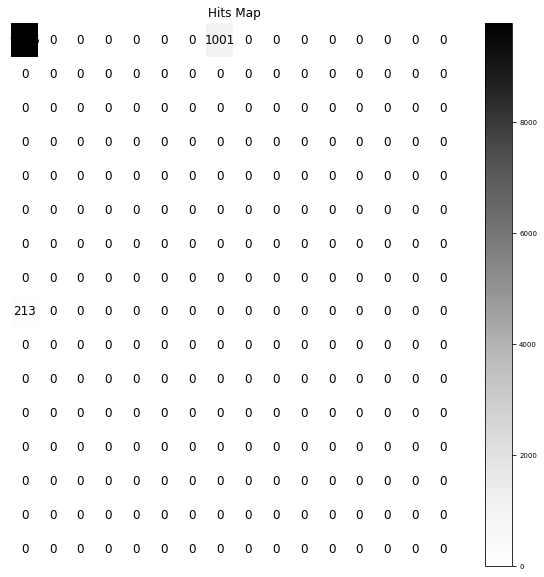

In [34]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model_2, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [35]:
 m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [36]:
distances = get_anomaly_score(transformed_data, 2, m)

/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [37]:
unique_distances = get_anomaly_score(unique_message_vectors.values(),2,m)
print(unique_message_vectors.keys())
unique_distances

dict_keys(['DEBUG', 'THRED', 'FP'])


/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[1.891009670738972, 0.1356080530081979, 1.2178702487540334]

The anomaly score seems odd here. The least frequent value has the lowest anomaly score...?
Why?

In [38]:
set(distances)

{1.8270765755623604, 1.8643919026947395, 1.8910096903094653}

In [39]:
th = np.mean(distances) + np.std(distances)
print(th)
for i in set(distances):
    print(i > th, i)


1.8943313609122097
False 1.8910096903094653
False 1.8643919026947395
False 1.8270765755623604


In [40]:
 m2 = model_2.codebook.matrix.reshape([16, 16, FP_Data.shape[1]])

In [41]:
distances_2 = get_anomaly_score(FP_Data, 2, m2)

In [42]:
set(distances_2)

{0.06921963226615602, 0.23759349702946264, 0.2894953948942903}

In [43]:
print(transformed_data[6188])
print(FP_Data[-1])

[0.04579642 0.11827677 0.12030392]
[0.04579642 0.11827677 0.12030392]


In [44]:
d1m = np.mean(distances)
d1s = np.std(distances)

d2m = np.mean(distances_2)
d2s = np.std(distances_2)

d1 = abs(distances[6188]-d1m)/d1s
d2 = abs(distances_2[-1]-d2m)/d2s

print(distances[6188])
print(distances_2[-1])

distances[6188] >= distances_2[-1]

1.8270765755623604
0.06921963226615602


True

In [45]:
d1m

1.8904363381217977

In [46]:
d1s

0.0038950227904120107

In [47]:
d1

16.26685284497018

In [48]:
d2

3.1404300024983702

In [49]:
d1 > d2

True

In [50]:
# Change training to random sampling 
np.random.seed(42)
x, _ = SOM.SOM(transformed_data,24 ,len(transformed_data))
np.random.seed(42)
y, _ = SOM.SOM(FP_Data,24,len(FP_Data))

KeyboardInterrupt: 

In [ ]:
plt.imshow(x)

In [ ]:
plt.imshow(y)

In [ ]:
distances = get_anomaly_score(transformed_data, 2, x)
distances_2 = get_anomaly_score(FP_Data, 2, y)
print(distances[6188])
print(distances_2[-1])
distances[6188] >= distances_2[-1]

In [ ]:
unique_distances = get_anomaly_score(unique_message_vectors.values(),2,x)
print(unique_message_vectors.keys())
unique_distances

In [ ]:
unique_distances = get_anomaly_score(unique_message_vectors.values(),2,y)
print(unique_message_vectors.keys())
unique_distances


my implementation appears to be behaving as expected: the lower frequency ==> higher initial score. what is the SOMPY model doing differently? 

In [ ]:
d1m = np.mean(distances)
d1s = np.std(distances)

d2m = np.mean(distances_2)
d2s = np.std(distances_2)

d1 = abs(distances[6188]-d1m)/d1s
d2 = abs(distances_2[-1]-d2m)/d2s

print(distances[6188])
print(distances_2[-1])

distances[6188] >= distances_2[-1]

In [ ]:
# Change training to random sampling 
np.random.seed(42)
x, _ = SOM.SOM(transformed_data,24 ,len(transformed_data))
np.random.seed(42)
y, _ = SOM.SOM(FP_Data[10000:],24,1000,x)

In [ ]:
plt.imshow(x)

In [ ]:
plt.imshow(y)

In [ ]:
distances = get_anomaly_score(transformed_data, 2, x)
distances_2 = get_anomaly_score(FP_Data, 2, y)
print(distances[6188])
print(distances_2[-1])
distances[6188] >= distances_2[-1]

In [ ]:
d1m = np.mean(distances)
d1s = np.std(distances)

d2m = np.mean(distances_2)
d2s = np.std(distances_2)

d1 = abs(distances[6188]-d1m)/d1s
d2 = abs(distances_2[-1]-d2m)/d2s

print(distances[6188])
print(distances_2[-1])

distances[6188] >= distances_2[-1]